# IMDB reviews sentiment classification dataset

## 1. Data loading and preprocessing
- load the data, split into train and val
- create unigrams from the text using `CountVectorizer`

## 2. Logistic Regression on unigrams (BoW)

## 3. Logistic Regression on uni/bi/tri-grams

## 4. Tokenization, stemming, lemmatization
With `spacy` and `nltk`

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## 1. Data loading and preprocessing

In [3]:
PATH = "data\\IMDB Dataset.csv"
df = pd.read_csv(PATH)
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df.review, df.sentiment)

In [6]:
np.unique(y_valid), np.unique(y_train)

(array(['negative', 'positive'], dtype=object),
 array(['negative', 'positive'], dtype=object))

In [7]:
# Replace "negative" by 0 and "positive" by 1
y_train = np.where(y_train == "negative", 0, 1)
y_valid = np.where(y_valid == "negative", 0, 1)

In [8]:
np.bincount(y_valid), np.bincount(y_train)

(array([6293, 6207], dtype=int64), array([18707, 18793], dtype=int64))

## Representing text as a bag-of-words
One of the more effective and simple representation of text for NLP tasks is a **bag of words**. In BoW we discard any information about structure or succession of words. BoW only tells us a word and how many times that word appeared

### Steps in computing BoW representation
- tokenization
- vocabulary building (collecting words that appeared in alphabetical order)
- encoding

### Sidetrack: BoW on a toy dataset

In [9]:
bards_words = ["The fool doth think he is wise,", "but the wise man knows himself to be a fool"]
toy_vect = CountVectorizer()
toy_vect.fit(bards_words)

print(f"Vocabulary size: {len(toy_vect.vocabulary_)}")
print(f"Vocabulary content:\n {toy_vect.vocabulary_}")

bag_of_words = toy_vect.transform(bards_words)
print(f"BoW:\n{bag_of_words.toarray()}")

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}
BoW:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


Meaning of the BoW array:

The words are sorted in an alphabetical order, each row represents one element in the `bards_words` array. 'be' is the first word and occurs 0 times in the first sentence.

### BoW on the imdb dataset

In [10]:
vect = CountVectorizer()
trn_term_doc = vect.fit_transform(X_train)
val_term_doc = vect.transform(X_valid)
trn_term_doc.shape

(37500, 90491)

In [11]:
feature_names = vect.get_feature_names()
print(len(feature_names))
print(f"{feature_names[5000:5005]}")

90491
['argeninian', 'argent', 'argentin', 'argentina', 'argentine']


## 2. Logistic Regression on unigrams

In [12]:
from sklearn.linear_model import LogisticRegression
m = LogisticRegression(C=1e8, dual=True)
m.fit(trn_term_doc, y_train)
preds = m.predict(val_term_doc)
(preds==y_valid).mean()

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\terez\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8736

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(trn_term_doc, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.89
Best parameters:  {'C': 0.1}


### Ways to improve the representation

#### By dropping some words
- Use only tokens that appear at least `n` times in the corpus (1 by default)
- Use stop words

In [14]:
vect = CountVectorizer(min_df=5)
trn_term_doc = vect.fit_transform(X_train)
val_term_doc = vect.transform(X_valid)

m = LogisticRegression(C=0.1, dual=True)
m.fit(trn_term_doc, y_train)
preds = m.predict(val_term_doc)
(preds==y_valid).mean()

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8944

In [15]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Every 10th stopword:
['etc', 'thereby', 'much', 'show', 'around', 'when', 'only', 'through', 'during', 'besides', 'sixty', 'twelve', 'fifteen', 'bottom', 'forty', 'down', 'can', 'others', 'fill', 'co', 'un', 'together', 'hereafter', 'otherwise', 'all', 'moreover', 'becoming', 'what', 'done', 'thru', 'became', 'whereas']


In [16]:
vect = CountVectorizer(min_df=5, stop_words="english")
trn_term_doc = vect.fit_transform(X_train)
val_term_doc = vect.transform(X_valid)

m = LogisticRegression(C=0.1, dual=True)
m.fit(trn_term_doc, y_train)
preds = m.predict(val_term_doc)
(preds==y_valid).mean()

0.8924

### Ways to improve the representation

#### By rescaling the data by how informative we expect them to be
Use so-called `frequency-inverse document frequency`. E.g. if a word appearch often in a particular document but not in others, it's likely to be descriptive of that document.
- the representation of each document is also rescaled to have Euclidean norm 1

Note that this is an unsupervised technique, doesn't necessairly relate to neg. vs. pos. review

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression())

param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
g = GridSearchCV(pipe, param_grid, cv=5)
g.fit(X_train, y_train)
print(f"Best cross-validation score: {g.best_score_}")

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.8967733333333333


Visualize what the model actually learned from the data (Log Regression's coefficients)

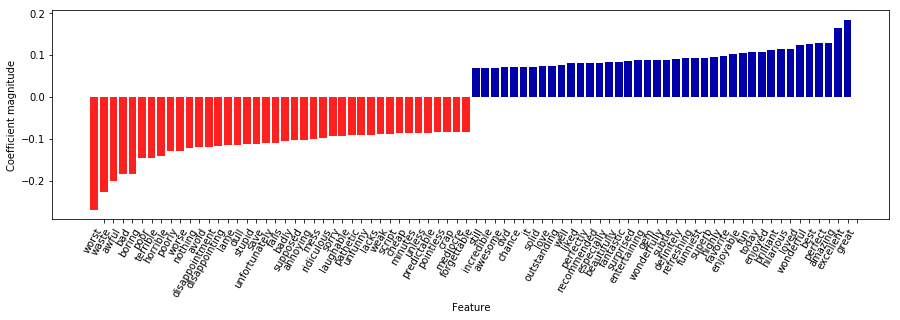

In [18]:
import mglearn
vectorizer = g.best_estimator_.named_steps["tfidfvectorizer"]
feature_names = np.array(vectorizer.get_feature_names())
mglearn.tools.visualize_coefficients(g.best_estimator_.named_steps["logisticregression"].coef_,
feature_names, n_top_features=40)

## 3. Logistic Regression on uni/bi/tri-grams
Disadsvantage of BoW = word succession is discarded, so "not bad" is effectively turned into "bad". Solutio = 

In [19]:
vect = CountVectorizer(ngram_range=(1,3))
trn_term_doc = vect.fit_transform(X_train)
val_term_doc = vect.transform(X_valid)
trn_term_doc.shape

(37500, 7146263)

In [20]:
vocab = vect.get_feature_names(); vocab[5000:5005]

['1000 words about',
 '1000 words allowed',
 '1000 words and',
 '1000 yards',
 '1000 yards of']

In [21]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(trn_term_doc, y_train);

preds = m.predict(val_term_doc)
(preds.T==y_valid).mean()

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.90768

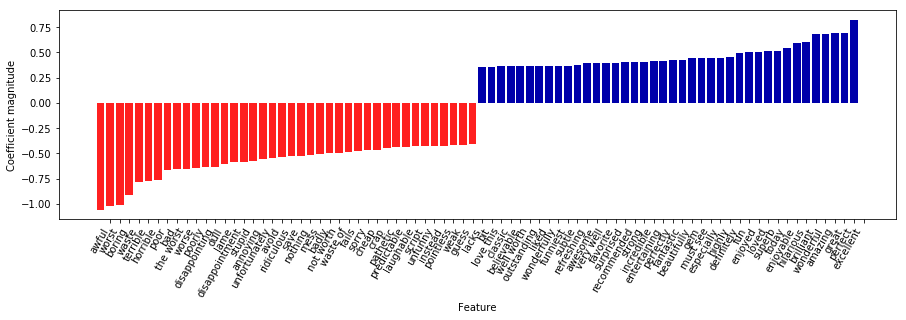

In [22]:
mglearn.tools.visualize_coefficients(m.coef_, np.array(vocab), n_top_features=40)

Note e.g. the "not worth"'s placing

## 4. Tokenization, stemming, lemmatization
- to help with generalization, it's useful to consider different for of the same root word as a 1 entity in the alphabet = representing each word using its word **stem** (the process is called stemming if rule-based heuristic is used, if a dictionary of known word forms is used, it's called **lemmatization**), both are examples of **normalization = trying to find a normal form of a word**. 

In [23]:
import spacy
import nltk
en_nlp = spacy.load('en')
stemmer = nltk.stem.PorterStemmer()

doc = u"Our meeting today was worse than yesterday, "
"I'm scared of meeting the clients tomorrow."

doc_spacy = en_nlp(doc)
print("Lemmatization")
print([token.lemma_ for token in doc_spacy])
print("Stemming")
print([stemmer.stem(token.norm_lower()) for token in doc_spacy])

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

Differences:
- `was` -> `wa` (stemming), `be` (lemmatization)
- `worse` -> `wors` (stemming), `bad` (lemmatization)

Lemmatization often produces better results that stemming

## Topic modeling - Latent Dirichlet Allocation 

In [ ]:
# Limit the n. of words to 10k
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(X_train)
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=10, learning_method="batch", max_iter=25, random_state=0)
document_topics = lda.fit_transform(X)

In [ ]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)